# Modeling

## Initialization

### Modules

In [1]:
# Main libs
import numpy as np
import pandas as pd
import optuna

# Modeling and evaluation
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
import shap
from catboost import CatBoostRegressor, Pool
import mlflow
import mlflow.xgboost as mlf
from mlflow.models.signature import infer_signature

# System environment optimisation tools 
import itertools
import time
import gc

# Additional environment optimisation tools
from tqdm import notebook
import tqdm
from time import sleep
import time

# Visualisation
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt


from pathlib import Path
import sys
ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.fsp_ms.config import Config

c:\Users\Мариан\Desktop\Jupyter Notes\Projects\Trainee_iFortex\Git\future_sales_predictions backup\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config() # TO DELETE LATER, USED FOR FAST EXPERIMENTING
full_df = pd.read_parquet(config.get('features'), engine='pyarrow')

### MLFlow init

In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

### Data and config init

In [4]:
config = Config()

In [5]:
full_df = pd.read_parquet(config.get('features'), engine='pyarrow')

In [6]:
train = full_df[full_df['date_block_num'] < 32]
train_x = train.drop('target', axis=1)
train_y = train['target']

validation = full_df[full_df['date_block_num'] == 32]
validation_x = validation.drop('target', axis=1)
validation_y = validation['target']

test = full_df[full_df['date_block_num'] == 33]
test_x = test.drop('target', axis=1)
test_y = test['target']

# predict_for = full_df[full_df['date_block_num'] == 34].drop('target', axis = 1)

### Probled Description

We should predict target for 34th month which is number of sold items in exact shop during "this" month. We have dataframe with all features and test+train conctated - full_df

In [7]:
some = pd.read_csv(config.get('submission'))
some

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


### Checking DF structure and Data consistency

In [ ]:
full_df.isna().sum().sum()

In [ ]:
full_df.tail(5)

## Base predict

### Predicting for "test" set 

Chossing target value from previous month as a prediction for 33rd month

Here we use validation set for the predict, cause of baseline assumption about importaness of 'target_lag_1' feature.

In [4]:
validation_base = full_df[full_df['date_block_num'] == 33][['date_block_num', 'shop_id', 'item_id', 'target_lag_1']]
validation_base = validation_base.rename({'target_lag_1':'target'}, axis=1).drop('date_block_num', axis= 1)
validation_base

,shop_id,item_id,target
10574777,2,2791,6.0
10574778,2,3351,20.0
10574779,2,3353,6.0
10574780,2,3708,2.0
10574781,2,4388,0.0
...,...,...,...
10812856,36,14199,0.0
10812857,36,6464,0.0
10812858,36,3327,0.0
10812859,36,19370,0.0


Evaluating error if we take target_lag_1 as our prediction

In [7]:
root_mean_squared_error(y_true=full_df[full_df['date_block_num'] == 33]['target'], y_pred = validation_base['target'])

1.1730363368988037

RMSE : 1.17303


In [15]:
y_true = full_df[full_df['date_block_num'] == 33]['target']
y_true

10574777    1.0
10574778    4.0
10574779    3.0
10574780    2.0
10574781    1.0
           ... 
10812856    0.0
10812857    0.0
10812858    0.0
10812859    0.0
10812860    0.0
Name: target, Length: 238084, dtype: float32

In [19]:
y_pred = validation_base['target']
y_pred

10574777     6.0
10574778    20.0
10574779     6.0
10574780     2.0
10574781     0.0
            ... 
10812856     0.0
10812857     0.0
10812858     0.0
10812859     0.0
10812860     0.0
Name: target, Length: 238084, dtype: float32

In [22]:
mean_absolute_error(y_true=y_true, y_pred = y_pred)

0.3035021126270294

MAE = 0.3035

In [23]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)+0.000001) / 2
    diff = np.abs(y_true - y_pred)
    smape_values = np.where(denominator == 0, 0, diff / denominator)
    return np.mean(smape_values) * 100

In [28]:
smape(y_true=y_true, y_pred=y_pred)

np.float32(32.04871)

SMAPE : 32%

### Linear regression

In [ ]:
linreg = LinearRegression() # Validation haven't used, it's reserved
linreg.fit(X= train_x, y = train_y )
preds_linreg = linreg.predict(test_x)
root_mean_squared_error(y_true=test_y, y_pred = preds_linreg)

### Predicting for inference set

Chossing target value from previous month as a prediction for test set

In [30]:
test_base = full_df[full_df['date_block_num'] == 34][['date_block_num', 'shop_id', 'item_id', 'target_lag_1']]
test_base = test_base.rename({'target_lag_1':'item_cnt_month'}, axis=1).drop('date_block_num', axis= 1).reset_index(drop= True)
test_base['ID'] = test_base.index
test_base = test_base[['ID','shop_id','item_id', 'item_cnt_month']]
test_base['item_cnt_month'] = test_base['item_cnt_month'].clip(0,20)

In [31]:
test_base.drop(['shop_id','item_id'], axis = 1).to_csv(config.get('predict_base'),index=False)

Result:

![kaggle_base_predict_taget_lag_1](../img/base_predicted_target_lag_1_clipping.jpg)

Private score: 1.15555 , Public Score: 1.15714

The same, but without clipping:

![kaggle_base_predict_taget_lag_1](../img/base_predicted_target_lag_1.jpg)

Private score: 1.40654 , Public Score: 1.52832

We basically use this approach for evaluation because, in time-series problems, the model is more likely to treat the target value from the previous month as an important feature. It seems to be the most basic and conventional approach.

# XGBOOST

## 128features_XGBOOST_EARLY_STOPPING_OPTIMIZATION. Hold out optimisation on 33rd month for fast feature importance (XGBOOST)

We would like to select features based on feature importance of a model which we already build, that will reduce time for hyperopt optimisation based on expanding window. Down below we use optimisation and then permutatuin feature importance.

In [ ]:
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "early_stopping_rounds": 20,
        'tree_method': 'hist',
        "device" : "cuda"
        
    }

    model = xgb.XGBRegressor(**param)
    model.fit(X = train_x, y = train_y, eval_set=[(validation_x, validation_y)], verbose=False)

    preds = model.predict(test_x)
    rmse = root_mean_squared_error(y_true=test_y, y_pred=preds)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)
#, early_stopping_rounds=20,

In [ ]:
# import mlflow
# import mlflow.xgboost as mlf
# # from mlflow.models.signature import infer_signature

# # mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("Hyperopt")

# # with mlflow.start_run(run_name='holdout_train_val_test'):
# #     mlflow.log_params(study.best_params)
# #     mlflow.log_metric('rmse', study.best_value)
# #     mlflow.set_tag("comment", "This was a baseline run without model logging.")
# # # Commented to avoid creating new expirements

In [ ]:
print(mlflow.get_tracking_uri())

In [ ]:
# holdout_train_val_test run : 
# Best params: {'n_estimators': 243, 'max_depth': 8, 'learning_rate': 0.05544865797304804, 'subsample': 0.9990261565478662, 'colsample_bytree': 0.8804292337411381, 'gamma': 1.004572997124911, 'lambda': 0.7534895371309323, 'alpha': 5.226914767230857}
# Best RMSE: 0.9213665723800659

## Naive Feature importance

Model based trained on all data except indeference

In [ ]:
%%time

params = {'n_estimators': 243, 'max_depth': 8, 'learning_rate': 0.05544865797304804,\
     'subsample': 0.9990261565478662, 'colsample_bytree': 0.8804292337411381,\
         'gamma': 1.004572997124911, 'lambda': 0.7534895371309323, 'alpha': 5.226914767230857}



train = full_df[full_df['date_block_num'] < 34]
train_x = train.drop('target', axis=1)
train_y = train['target']

test = full_df[full_df['date_block_num'] == 34]
test_x = test.drop('target', axis=1)


model = xgb.XGBRegressor(**params)
model.fit(train_x, train_y)



Taking out inner data from state of the model

In [14]:
# Get feature importances
booster = model.get_booster()

# Importance types: "weight", "gain", "cover", "total_gain", "total_cover"
importance = booster.get_score(importance_type='gain')

# Convert to DataFrame for readability
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

importance_df['importance_precentage']= importance_df['Importance'] / importance_df['Importance'].sum()

In [15]:
importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

In [ ]:
importance_df.head(50)

In [ ]:
importance_df['Importance'].hist(bins=500)

Choosing features by threshold

In [ ]:
important_features = list(importance_df[importance_df['Importance'] > 0.006]['Feature'])
important_features

Above here we can see that the most important feature is target_lag_1 and lags from expanding window aggregations as target_aggregated_max_premonthes_item_id_lag_2, target_aggregated_max_premonthes_item_id_shop_, target_aggregated_max_premonthes_item_id_shop_id. Not the less important: first_month_item_id it's a binary feature responsible for the fact item is selling first time in this month.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 50))  
xgb.plot_importance(model, importance_type='gain', ax=ax)
plt.tight_layout()
plt.savefig("feature_importance.png")

In [ ]:
y_pred

### Making Predictions with holdout hyperopt estimate model params

In [ ]:
dmatrix = xgb.DMatrix(data=test_x)
y_pred = model.predict(test_x)

In [ ]:
y_pred

In [ ]:
y_pred = np.clip(y_pred, 0, 20)
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['item_cnt_month']

df_y_pred['ID'] = df_y_pred.index
df_y_pred = df_y_pred[['ID','item_cnt_month']]
df_y_pred[df_y_pred['item_cnt_month'] > 0]

In [ ]:
df_y_pred.to_csv(config.get('predict'), index= False)

![kaggle_base_predict_taget_lag_1](../img/hold_out_opt_xgb_prediction.png)

Private score: 0.91109 Public Score: 0.93163

## Important_features_Optimisation_Predict_Expanding_Window (XGBOOST)

In [29]:
# X = full_df[full_df['date_block_num'] != 34].drop(columns='target', axis=1)
# y = full_df[full_df['date_block_num'] != 34]['target']

X = pd.read_parquet(config.get('train_x'))
y = pd.read_parquet(config.get('train_y'))


In [ ]:
# important_features.extend(['shop_id','city','date_block_num'])
# important_features


In [12]:
important_features = ['target_lag_1',
 'target_aggregated_max_premonthes_item_id_shop_id_lag_1',
 'target_aggregated_mean_premonthes_item_id_shop_id',
 'target_aggregated_max_premonthes_item_id_shop_id',
 'target_item_category_id_mean_lag_2',
 'target_aggregated_max_premonthes_item_id_lag_2',
 'target_predict_2_3',
 'first_month_item_id',
 'target_aggregated_max_premonthes_item_id_shop_id_lag_2',
 'item_category_id',
 'target_item_id_mean_lag_1',
 'item_id_was_in_test',
 'was_item_cnt_day_outlier_lag_1',
 'target_general_item_category_name_total_predict_1_2',
 'target_aggregated_max_premonthes_item_id',
 'target_item_id_total_lag_1',
 'target_general_item_category_name_total_predict_2_3',
 'target_lag_2',
 'month',
 'target_aggregated_mean_premonthes_shop_id_lag_1',
 'target_aggregated_mean_premonthes_shop_id',
 'target_item_category_id_total_delta_1_2',
 'target_item_id_total_predict_1_2',
 'target_lag_3',
 'target_aggregated_mean_premonthes_item_id_lag_3',
 'target_item_category_id_total_predict_1_2',
 'target_general_item_category_name_mean_lag_2',
 'target_shop_id_total_delta_1_2',
 'target_general_item_category_name_total_lag_1',
 'target_item_category_id_total_lag_1',
 'target_general_item_category_name_mean_lag_1',
 'target_shop_id_total_predict_2_3',
 'shop_id',
 'city',
 'date_block_num', 'item_id']

In [31]:
columns_to_drop = [x for x in X.columns if x not in important_features]
columns_to_drop
X = X.drop(columns=columns_to_drop, axis=1)


In [32]:
X.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'city',
       'item_id_was_in_test', 'first_month_item_id',
       'target_aggregated_mean_premonthes_item_id_shop_id',
       'target_aggregated_max_premonthes_item_id_shop_id',
       'target_aggregated_max_premonthes_item_id',
       'target_aggregated_mean_premonthes_shop_id', 'month', 'target_lag_1',
       'target_item_id_total_lag_1', 'target_item_id_mean_lag_1',
       'target_item_category_id_total_lag_1',
       'target_general_item_category_name_total_lag_1',
       'target_general_item_category_name_mean_lag_1',
       'target_aggregated_max_premonthes_item_id_shop_id_lag_1',
       'target_aggregated_mean_premonthes_shop_id_lag_1',
       'was_item_cnt_day_outlier_lag_1', 'target_lag_2',
       'target_item_category_id_mean_lag_2',
       'target_general_item_category_name_mean_lag_2',
       'target_aggregated_max_premonthes_item_id_shop_id_lag_2',
       'target_aggregated_max_premonthes_item_id_lag_2', 

In [33]:
X.shape[0] == len(y)

True

In [ ]:

def evaluate_expanding_window(X, y, month_column, start_val_month=25, end_val_month=33, model_params=None, trial = None):
    """
    Evaluate a model using expanding window strategy on months [start_val_month, ..., end_val_month].

    X, y: full dataset features and targets
    month_column: Series with month number (1–33)
    model_params: dict of parameters for the XGBRegressor

    Returns: average RMSE across folds
    """
    rmses = []

    for idx, val_month in enumerate(range(start_val_month, end_val_month + 1)):
        # Train on all months strictly before val_month
        train_mask = month_column < val_month
        val_mask = month_column == val_month

        X_train, y_train = X.loc[train_mask], y.loc[train_mask]
        X_val, y_val = X.loc[val_mask], y.loc[val_mask]

        model = xgb.XGBRegressor(**model_params)
        
        model.fit(X = X_train,y = y_train)

        preds = model.predict(X_val)
        rmse = root_mean_squared_error(y_pred= preds, y_true = y_val)
        rmses.append(rmse)

        # # Logging current progress
        # if trial is not None:
        #     intermediate_value = np.mean(rmses)
        #     trial.report(intermediate_value, step=idx)

        # # Checking if we need to stop
        #     if trial.should_prune():
        #         raise optuna.TrialPruned()

    return np.mean(rmses)


def objective(trial):
    params = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        #"n_jobs": 5
        'tree_method': 'hist',
        #"max_bins":64, 
        "device" : "cuda"
    }

    return evaluate_expanding_window(
        X=X,
        y=y,
        month_column=X['date_block_num'],  # pd.Series with values 1 to 33
        start_val_month=25,
        end_val_month=33,
        model_params=params,
        trial=trial
    )

#pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=4, interval_steps=1)
study = optuna.create_study(direction="minimize") #, pruner=pruner
study.optimize(objective, n_trials=50) # timeout=900 15n minutes maximum for one cycle

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

In [13]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [ ]:
mlflow.set_experiment("Hyperopt")

In [ ]:
with mlflow.start_run(run_name='Hyperopt_important_features'):
    mlflow.log_params(study.best_params)
    mlflow.log_metric('rmse', study.best_value)
    mlflow.set_tag("comment", "This was a baseline run without model logging.")


In [ ]:
print(mlflow.get_tracking_uri())

## Predicting for optimised cross val XGBOOST based on important features from hold out

### SMAPE

In [15]:
important_features

['target_lag_1',
 'target_aggregated_max_premonthes_item_id_shop_id_lag_1',
 'target_aggregated_mean_premonthes_item_id_shop_id',
 'target_aggregated_max_premonthes_item_id_shop_id',
 'target_item_category_id_mean_lag_2',
 'target_aggregated_max_premonthes_item_id_lag_2',
 'target_predict_2_3',
 'first_month_item_id',
 'target_aggregated_max_premonthes_item_id_shop_id_lag_2',
 'item_category_id',
 'target_item_id_mean_lag_1',
 'item_id_was_in_test',
 'was_item_cnt_day_outlier_lag_1',
 'target_general_item_category_name_total_predict_1_2',
 'target_aggregated_max_premonthes_item_id',
 'target_item_id_total_lag_1',
 'target_general_item_category_name_total_predict_2_3',
 'target_lag_2',
 'month',
 'target_aggregated_mean_premonthes_shop_id_lag_1',
 'target_aggregated_mean_premonthes_shop_id',
 'target_item_category_id_total_delta_1_2',
 'target_item_id_total_predict_1_2',
 'target_lag_3',
 'target_aggregated_mean_premonthes_item_id_lag_3',
 'target_item_category_id_total_predict_1_2',
 '

In [14]:
important_features.extend(['target'])

In [16]:
full_df = full_df[important_features]

In [17]:
train_x, train_y, test_x, test_y = train_x_y_test_x_y(full_df=full_df)

In [27]:
%%time

params =  {'n_estimators': 192, 'max_depth': 9, \
'learning_rate': 0.018270981823248666, \
    'subsample': 0.7539246424525929, 'colsample_bytree': 0.562829755261984,\
         'gamma': 0.3153933459249693, 'lambda': 0.1718951364361902, \
            'alpha': 0.26986966152618785}

model = xgb.XGBRegressor(**params)
model.fit(train_x, train_y)


CPU times: total: 28min 4s
Wall time: 2min 14s


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.562829755261984
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [34]:
df_y_pred = model_predict(model=model, inference_for = test_x)

In [31]:
test_y = np.clip(test_y, 0, 20)

In [35]:
smape(y_true = test_y,  y_pred = df_y_pred['item_cnt_month'] )

np.float32(187.02428)

SMAPE : 187% (??)

In [38]:
mean_absolute_error(y_true=test_y, y_pred= df_y_pred['item_cnt_month'] )

0.33153387904167175

In [39]:
root_mean_squared_error(y_true=test_y, y_pred= df_y_pred['item_cnt_month'] )

1.1035484075546265

### Inference and other

In [ ]:
def model_predict(model, inference_for: pd.DataFrame=None):
    inference_y = model.predict(inference_for)
    inference_y = np.clip(inference_y, 0, 20)
    df_y_pred = pd.DataFrame(inference_y)
    df_y_pred.columns = ['item_cnt_month']
    
    df_y_pred['ID'] = df_y_pred.index
    df_y_pred = df_y_pred[['ID','item_cnt_month']]
    return df_y_pred


In [ ]:
%%time

params =  {'n_estimators': 192, 'max_depth': 9, \
'learning_rate': 0.018270981823248666, \
    'subsample': 0.7539246424525929, 'colsample_bytree': 0.562829755261984,\
         'gamma': 0.3153933459249693, 'lambda': 0.1718951364361902, \
            'alpha': 0.26986966152618785}

model = xgb.XGBRegressor(**params)
model.fit(train_x, train_y)


In [35]:
inference_for = pd.read_parquet(config.get('inference'))
inference_for = inference_for.drop(columns = columns_to_drop, axis=1)

In [37]:
result = model_predict(model = model, inference_for=inference_for)

In [ ]:
result.to_csv(config.get('predict'),index=False)

![important_features_optimised_cross_val](../img/important_features_optimised_cross_val.png)

Private Score: 0.89922 Public Score: 0.90480

### Shap

In [52]:
explainer = shap.TreeExplainer(model)

In [53]:
shap_values = explainer(X.sample(100, random_state=42))

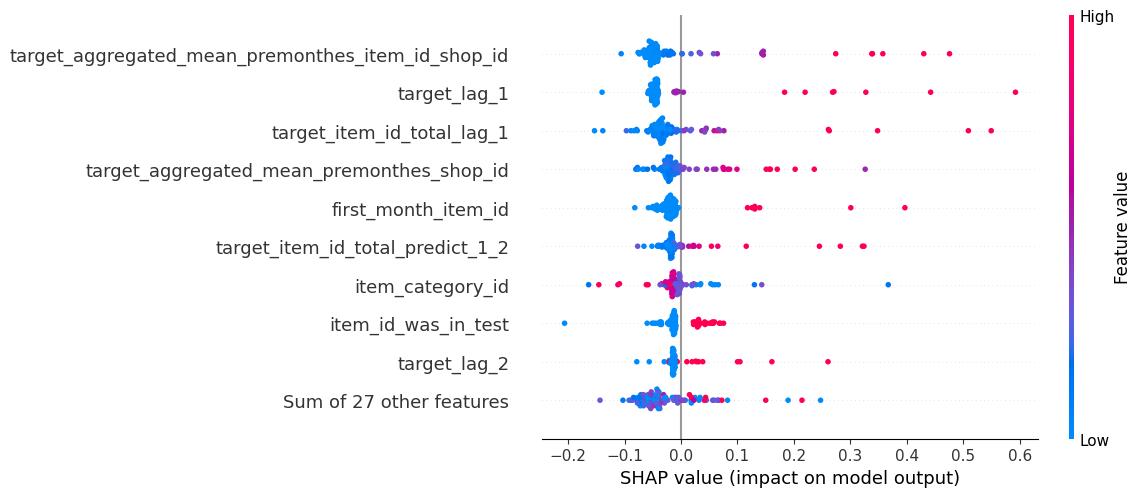

In [54]:
shap.plots.beeswarm(shap_values)

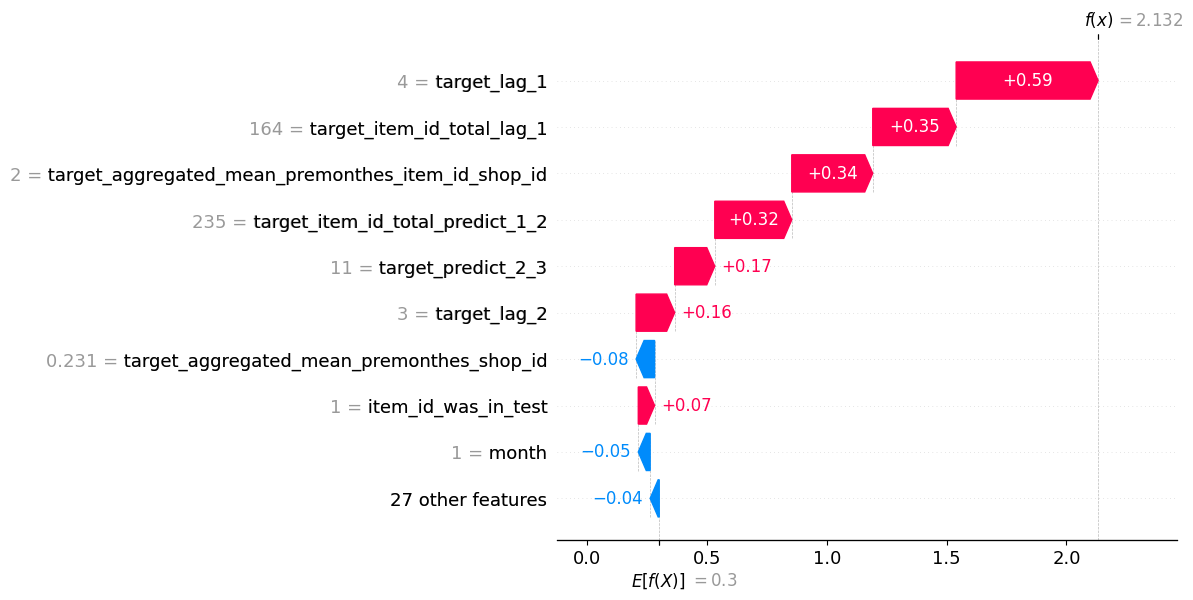

In [57]:
shap.plots.waterfall(shap_values[7])

# Add some usefull functions

### Data for train and simple evaluation

In [3]:
# def train_x_y_val_x_y_test_x_y(full_df):
#     train = full_df[full_df['date_block_num'] < 32]
#     train_x = train.drop('target', axis=1)
#     train_y = train['target']

#     validation = full_df[full_df['date_block_num'] == 32]
#     validation_x = validation.drop('target', axis=1)
#     validation_y = validation['target']

#     test = full_df[full_df['date_block_num'] == 33]
#     test_x = test.drop('target', axis=1)
#     test_y = test['target']
#     return train_x, train_y, validation_x, validation_y, test_x, test_y


In [4]:
def train_x_y_test_x_y(full_df):
    train = full_df[full_df['date_block_num'] < 33]
    train_x = train.drop('target', axis=1)
    train_y = train['target']

    test = full_df[full_df['date_block_num'] == 33]
    test_x = test.drop('target', axis=1)
    test_y = test['target']
    return train_x, train_y, test_x, test_y


In [5]:
def evaluate_hold_out(trained_model, test_x, test_y):
    prediction = trained_model.predict(test_x)
    return root_mean_squared_error(y_true=test_y, y_pred=prediction)

### Final inference

Used for trained model to make predictions

In [34]:
def x_y_inference_for(config: Config = Config() ):
    X = pd.read_parquet(config.get('train_x'))
    y = pd.read_parquet(config.get('train_y'))
    inference_for = pd.read_parquet(config.get('inference'))
    return X, y, inference_for # Get Training and inference data for submission 

You pass trained model and inference set and get prediction in sumbission format

In [35]:
def model_predict(trained_model, inference_for: pd.DataFrame=None, save: bool=False):
    inference_y = trained_model.predict(inference_for)
    inference_y = np.clip(inference_y, 0, 20)
    df_y_pred = pd.DataFrame(inference_y)
    df_y_pred.columns = ['item_cnt_month']
    
    df_y_pred['ID'] = df_y_pred.index
    df_y_pred = df_y_pred[['ID','item_cnt_month']]
    if save:
        df_y_pred.to_csv(config.get('predict'), index=False)
    return df_y_pred


In [36]:
def model_stabilitity_evaluation(X, y, month_column, start_val_month=25, end_val_month=33, model_with_params=xgb.XGBRegressor()):
    """
    Evaluate a model using expanding window strategy on months [start_val_month, ..., end_val_month].

    X, y: full dataset features and targets
    month_column: Series with month number (1–33)
    model_params: model with defined params

    Returns: average RMSE across folds
    """
    rmses = []

    for val_month in range(start_val_month, end_val_month + 1):
        # Train on all months strictly before val_month
        train_mask = month_column < val_month
        val_mask = month_column == val_month

        X_train, y_train = X.loc[train_mask], y.loc[train_mask]
        X_val, y_val = X.loc[val_mask], y.loc[val_mask]

        
        model_with_params.fit(X = X_train,y = y_train)

        preds = model_with_params.predict(X_val)
        rmse = root_mean_squared_error(y_pred= preds, y_true = y_val)
        rmses.append(rmse)


    return np.mean(rmses)

### LinReg Preprocessing

In [37]:
def encoding_categories_target(df):
    categorical = ['shop_id','item_id','item_category_id', 'general_item_category_name'\
                        ,'city']
    for category in tqdm.tqdm(categorical):
        category_encoded_name = category + '_te'
        df[category_encoded_name] = 0

        for month in sorted(df['date_block_num'].unique()):
            past = df[df['date_block_num'] < month]
            current = df['date_block_num'] == month
            means = past.groupby(category)['target'].mean()
            df.loc[current, category_encoded_name] = df.loc[current, category].map(means)

    df = df.drop(columns=categorical, axis=1)
    df = df.fillna(0)
    return df   

In [24]:
def sin_cos_time_transformation(df):
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    year_start = df['year'].min()
    year_end = df['year'].max()
    df['year_norm'] = (df['year'] - year_start) / (year_end - year_start)
    df = df.drop(columns = ['year','month'], axis = 1)
    return df

In [25]:
def split_full_df(full_df):
    X = full_df[full_df['date_block_num'] < 34].drop(columns = 'target', axis = 1)
    y = full_df[full_df['date_block_num'] < 34]['target']
    inference_for = full_df[full_df['date_block_num'] == 34].drop(columns = 'target', axis = 1)
    return X, y, inference_for

In [26]:
# important_features = ['target_lag_1',
#  'target_aggregated_max_premonthes_item_id_shop_id_lag_1',
#  'target_aggregated_mean_premonthes_item_id_shop_id',
#  'target_aggregated_max_premonthes_item_id_shop_id',
#  'target_item_category_id_mean_lag_2',
#  'target_aggregated_max_premonthes_item_id_lag_2',
#  'target_predict_2_3',
#  'first_month_item_id',
#  'target_aggregated_max_premonthes_item_id_shop_id_lag_2',
#  'item_category_id',
#  'target_item_id_mean_lag_1',
#  'item_id_was_in_test',
#  'was_item_cnt_day_outlier_lag_1',
#  'target_general_item_category_name_total_predict_1_2',
#  'target_aggregated_max_premonthes_item_id',
#  'target_item_id_total_lag_1',
#  'target_general_item_category_name_total_predict_2_3',
#  'target_lag_2',
#  'month_te',
#  'target_aggregated_mean_premonthes_shop_id_lag_1',
#  'target_aggregated_mean_premonthes_shop_id',
#  'target_item_category_id_total_delta_1_2',
#  'target_item_id_total_predict_1_2',
#  'target_lag_3',
#  'target_aggregated_mean_premonthes_item_id_lag_3',
#  'target_item_category_id_total_predict_1_2',
#  'target_general_item_category_name_mean_lag_2',
#  'target_shop_id_total_delta_1_2',
#  'target_general_item_category_name_total_lag_1',
#  'target_item_category_id_total_lag_1',
#  'target_general_item_category_name_mean_lag_1',
#  'target_shop_id_total_predict_2_3',
#  'shop_id_te',
#  'city_te',
#  'date_block_num']
# columns_to_drop = [x for x in train_x.columns if x not in important_features]

In [27]:
# columns_to_scale = [x for x in train_x.columns if \
#                     (full_df[x].dtype == np.float32 or full_df[x].dtype == np.float64)\
#                           and "outlier" not in x]

### XGBOOST preprocessing

In [61]:
def full_df_drop_unimportant_features(full_df):
    important_features = ['target_lag_1',
        'target_aggregated_max_premonthes_item_id_shop_id_lag_1',
        'target_aggregated_mean_premonthes_item_id_shop_id',
        'target_aggregated_max_premonthes_item_id_shop_id',
        'target_item_category_id_mean_lag_2',
        'target_aggregated_max_premonthes_item_id_lag_2',
        'target_predict_2_3',
        'first_month_item_id',
        'target_aggregated_max_premonthes_item_id_shop_id_lag_2',
        'item_category_id',
        'target_item_id_mean_lag_1',
        'item_id_was_in_test',
        'was_item_cnt_day_outlier_lag_1',
        'target_general_item_category_name_total_predict_1_2',
        'target_aggregated_max_premonthes_item_id',
        'target_item_id_total_lag_1',
        'target_general_item_category_name_total_predict_2_3',
        'target_lag_2',
        'month',
        'target_aggregated_mean_premonthes_shop_id_lag_1',
        'target_aggregated_mean_premonthes_shop_id',
        'target_item_category_id_total_delta_1_2',
        'target_item_id_total_predict_1_2',
        'target_lag_3',
        'target_aggregated_mean_premonthes_item_id_lag_3',
        'target_item_category_id_total_predict_1_2',
        'target_general_item_category_name_mean_lag_2',
        'target_shop_id_total_delta_1_2',
        'target_general_item_category_name_total_lag_1',
        'target_item_category_id_total_lag_1',
        'target_general_item_category_name_mean_lag_1',
        'target_shop_id_total_predict_2_3',
        'shop_id',
        'city',
        'date_block_num', 'target', 'item_id']
    full_df = full_df[important_features]
    return full_df


In [29]:
# important_features = ['target_lag_1',
#  'target_aggregated_max_premonthes_item_id_shop_id_lag_1',
#  'target_aggregated_mean_premonthes_item_id_shop_id',
#  'target_aggregated_max_premonthes_item_id_shop_id',
#  'target_item_category_id_mean_lag_2',
#  'target_aggregated_max_premonthes_item_id_lag_2',
#  'target_predict_2_3',
#  'first_month_item_id',
#  'target_aggregated_max_premonthes_item_id_shop_id_lag_2',
#  'item_category_id',
#  'target_item_id_mean_lag_1',
#  'item_id_was_in_test',
#  'was_item_cnt_day_outlier_lag_1',
#  'target_general_item_category_name_total_predict_1_2',
#  'target_aggregated_max_premonthes_item_id',
#  'target_item_id_total_lag_1',
#  'target_general_item_category_name_total_predict_2_3',
#  'target_lag_2',
#  'month',
#  'target_aggregated_mean_premonthes_shop_id_lag_1',
#  'target_aggregated_mean_premonthes_shop_id',
#  'target_item_category_id_total_delta_1_2',
#  'target_item_id_total_predict_1_2',
#  'target_lag_3',
#  'target_aggregated_mean_premonthes_item_id_lag_3',
#  'target_item_category_id_total_predict_1_2',
#  'target_general_item_category_name_mean_lag_2',
#  'target_shop_id_total_delta_1_2',
#  'target_general_item_category_name_total_lag_1',
#  'target_item_category_id_total_lag_1',
#  'target_general_item_category_name_mean_lag_1',
#  'target_shop_id_total_predict_2_3',
#  'shop_id',
#  'city',
#  'date_block_num']


In [30]:
# columns_to_drop = [x for x in X.columns if x not in important_features]

# Linear Regression

In [ ]:
full_df['target'].hist()

We have Tweedie distribution for the target variable, with power ~ 1.6

### Scaling initialisation

In [ ]:
pd.DataFrame({
    "column": full_df.columns,
    "dtype": full_df.dtypes.values
})[100:-1]# Checking all columns types

In [ ]:
full_df = encoding_categories_target(full_df)


In [13]:
full_df = sin_cos_time_transformation(full_df)

In [ ]:
full_df.to_parquet(path= '../data/03_interim/lin_reg_full_df.parquet')

In [ ]:
full_df = pd.read_parquet('./data/03_interim/lin_reg_full_df.parquet')

In [9]:
train_x, train_y, test_x, test_y = train_x_y_test_x_y(full_df=full_df)

In [11]:
del full_df

In [12]:
scaler = StandardScaler()
train_x[columns_to_scale] = scaler.fit_transform(train_x[columns_to_scale])
test_x[columns_to_scale] = scaler.transform(test_x[columns_to_scale])

In [ ]:
train_x.to_parquet('./data/03_interim/lin_reg_train_x.parquet')
test_x.to_parquet('./data/03_interim/lin_reg_test_x.parquet')

In [ ]:
train_x = pd.read_parquet('./data/03_interim/lin_reg_train_x.parquet')
test_x = pd.read_parquet('./data/03_interim/lin_reg_test_x.parquet')

In [ ]:
train_x = train_x.drop(columns=columns_to_drop, axis=1)
test_x = test_x.drop(columns=columns_to_drop, axis=1)

### Evaluation and building predictions

In [ ]:
tweedie = TweedieRegressor(power=1.5, alpha=1.0)

tweedie.fit(X = train_x, y = train_y)
evaluate_hold_out(trained_model = tweedie, test_x = test_x, test_y = test_y)

### XGB on LinReg preprocessing - target encoding, standart scaler, cos sin time transformation

In [ ]:
%%time
params =  {'n_estimators': 192, 'max_depth': 9, \
'learning_rate': 0.018270981823248666, \
    'subsample': 0.7539246424525929, 'colsample_bytree': 0.562829755261984,\
         'gamma': 0.3153933459249693, 'lambda': 0.1718951364361902, \
            'alpha': 0.26986966152618785}
model = xgb.XGBRegressor(**params)
model.fit(train_x, train_y)

evaluate_hold_out(trained_model = model, test_x = test_x, test_y = test_y)

In [ ]:
%%time
model_stabilitity_evaluation(train_x, train_y, train_x['date_block_num'], start_val_month=23, end_val_month=31, model_with_params=xgb.XGBRegressor(**params))

In [24]:
full_df = pd.read_parquet('lin_reg_full_df.parquet')
full_df = full_df.drop(columns = columns_to_drop, axis=1)
X = full_df[full_df['date_block_num'] < 34].drop(columns = 'target', axis = 1)
y = full_df[full_df['date_block_num'] < 34]['target']
inference_for = full_df[full_df['date_block_num'] == 34].drop(columns = 'target', axis = 1)


In [ ]:
model_xgb_pred = xgb.XGBRegressor(**params)
model_xgb_pred.fit(X, y)

In [27]:
predicted = model_predict(trained_model=model_xgb_pred, inference_for=inference_for)

In [29]:
predicted.to_csv(config.get('predict'), index=False)

![xgbost_important_features_lin_reg_params]('../img/xgbost_important_features_lin_reg_params.png')

RMSE on board: Private : 0.96263, Public: 0.97100

# Final "tunning"

In [43]:
full_df = full_df_drop_unimportant_features(full_df=full_df)

In [44]:
X, y, inference_for = split_full_df(full_df= full_df)

In [47]:
categorical = ['shop_id','item_id','item_category_id'\
                        ,'city']

In [48]:
full_df[categorical] =  full_df[categorical].astype('category')

In [49]:
del full_df

Okey, we can see it's better to use less features, use xgboost, and don't over transform data. Now we have only one option to go, is to try use tweedie in xgboost, or use model as catboost, or/and use stacking of them 

### Tweedie as objective function

In [ ]:
%%time
params =  {'n_estimators': 192, 'max_depth': 9, \
'learning_rate': 0.018270981823248666, \
    'subsample': 0.7539246424525929, 'colsample_bytree': 0.562829755261984,\
         'gamma': 0.3153933459249693, 'lambda': 0.1718951364361902, \
            'alpha': 0.26986966152618785, 'objective': 'reg:tweedie', 'tweedie_variance_power': 1.5}
model = xgb.XGBRegressor(**params)
model.fit(X, y)
model_predict(trained_model=model, inference_for = inference_for, save=True)

Private_Score = 0.92917, Public_Score = 0.93147

### Try to mark categorical features

In [ ]:
params =  {'n_estimators': 192, 'max_depth': 9, \
'learning_rate': 0.018270981823248666, \
    'subsample': 0.7539246424525929, 'colsample_bytree': 0.562829755261984,\
         'gamma': 0.3153933459249693, 'lambda': 0.1718951364361902, \
            'alpha': 0.26986966152618785, 'eval_metric': 'rmse', \
                'device': 'cuda', 'tree_method':'hist', 'enable_categorical': True}

model = xgb.XGBRegressor(**params)
model.fit(X, y)
model_predict(trained_model=model, inference_for = inference_for, save=True)

Private Score: 0.90231
Public Score: 0.91108

### Catboost

In [ ]:
cat = CatBoostRegressor()
cat.fit(X,y)
model_predict(trained_model=cat, inference_for = inference_for, save=True)

Private score: 0.91352 ; Public Score: 0.92233

# Stacking

### Init

In [38]:
full_df = full_df_drop_unimportant_features(full_df=full_df)

In [39]:
X, y, inference_for = split_full_df(full_df= full_df)

In [40]:
del full_df

### Stacking functions and predicting

Important to run preprocessing at the begging of this block 

In [31]:
params = {'n_estimators': 192, 'max_depth': 9, \
'learning_rate': 0.018270981823248666, \
    'subsample': 0.7539246424525929, 'colsample_bytree': 0.562829755261984,\
         'gamma': 0.3153933459249693, 'lambda': 0.1718951364361902, \
            'alpha': 0.26986966152618785, 'eval_metric': 'rmse', \
                'tree_method':'hist', 'device': 'cuda', 'enable_categorical': True }

In [44]:
def stacking_with_expanding_model(X, y, predict_for, month_column, params, start_val_month=25, end_val_month=33):

    meta_features = []
    meta_X_predict_for_list= []

    for val_month in tqdm.tqdm(range(start_val_month, end_val_month + 1)):


        train_mask = month_column < val_month
        val_mask = month_column == end_val_month

        X_train = X.loc[train_mask]
        y_train = y.loc[train_mask]
        X_val = X.loc[val_mask]
        

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        meta_features.append(preds)

        # Following block dedicated to meta-model inference-data, with adding last month to prediction and skipping first from trainining set
        if val_month != 25:
            preds = model.predict(predict_for)
            meta_X_predict_for_list.append(preds)

        if val_month == 33:
            X_train = X
            y_train = y
            model = xgb.XGBRegressor(**params)
            model.fit(X,y)
            preds = model.predict(predict_for)
            meta_X_predict_for_list.append(preds)

        



        

    meta_X = np.vstack(meta_features).T
    y_target = y.loc[month_column == end_val_month ].values

    meta_model = xgb.XGBRegressor(**params)
    meta_model.fit(meta_X, y_target)
    
    meta_X_predict_for = np.vstack(meta_X_predict_for_list).T
    

    return meta_model, meta_X, y_target, meta_X_predict_for
# RETURNS TRAINED MODEL ⚠️

In [45]:
meta_model, meta_X, y_target, meta_X_predict_for = stacking_with_expanding_model(X = X,y = y, predict_for=inference_for, month_column = X['date_block_num'], params= params)

100%|██████████| 9/9 [06:23<00:00, 42.56s/it]


In [46]:
meta_X_predict_for

array([[0.3645564 , 0.35426536, 0.32538536, ..., 0.39712945, 0.3646357 ,
        0.35786688],
       [0.41198987, 0.37351948, 0.48966956, ..., 0.442549  , 0.48101288,
        0.48011905],
       [0.7775091 , 0.7532086 , 0.73485124, ..., 0.8547169 , 0.7725006 ,
        0.771461  ],
       ...,
       [0.09225795, 0.09448409, 0.08626582, ..., 0.08772375, 0.08898667,
        0.08985838],
       [0.03329596, 0.03259605, 0.03162825, ..., 0.03278422, 0.0339461 ,
        0.0344713 ],
       [0.08886334, 0.08583498, 0.08065441, ..., 0.07929087, 0.07370692,
        0.07853176]], shape=(214200, 9), dtype=float32)

In [47]:
inferenced = model_predict(trained_model= meta_model, inference_for= meta_X_predict_for, save = True)

Private score: 0.95928, Public score: 0.98085 - meta model is CatBoost


Score: 0.96975
Private score: 0.94763   - meta model is XGBoost with best optimisation params on cross validation for important features

Later i found a bottle neck, and decided to improve stacking_with_expanding_model() function. The problem was that for prediction data, our meta-model doesn't use any model which using 33rd month for training. At the notebook you see already improved version. That's a nice point to test how stacking might be improved with solving described case.  

Score: 0.95646
Private score: 0.94336



We've got very little imporvement, waht was expectable. 